In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy
import weat# assumes you have a `weat` module
import warnings
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask.dataframe as dd
from scipy import stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from IPython.display import display, HTML
import statsmodels.api as sm
from dask import delayed, compute
from dask import visualize
import glob

warnings.filterwarnings('ignore')

# Set base directory (adjust for Midway)
base_path = '/project/macs30123/output_embed/'

In [2]:
# Load and validate embeddings
def is_invalid_group(emb_X, emb_Y, emb_A, emb_B):
    groups = [emb_X, emb_Y, emb_A, emb_B]
    return any((len(g) == 0 or any(vec.shape != (4096,) for vec in g)) for g in groups)

# Process one layer file
@delayed
def process_layer(layer):
    search_pattern = f"/project/macs30123/output_embed/result_embed_l{layer}_proc*.parquet"
    candidates = sorted(glob.glob(search_pattern))
    input_path = candidates[0]
    data = dd.read_parquet(input_path)

    emb_X_list = [[np.array(e) for e in group] for group in data['emb_X']]
    emb_Y_list = [[np.array(e) for e in group] for group in data['emb_Y']]
    emb_A_list = [[np.array(e) for e in group] for group in data['emb_A']]
    emb_B_list = [[np.array(e) for e in group] for group in data['emb_B']]

    test_stat, valid_flags = [], []

    for emb_X, emb_Y, emb_A, emb_B in zip(emb_X_list, emb_Y_list, emb_A_list, emb_B_list):
        if is_invalid_group(emb_X, emb_Y, emb_A, emb_B):
            test_stat.append(None)
            valid_flags.append(False)
        else:
            ts = weat.weat_differential_association(emb_X, emb_Y, emb_A, emb_B)
            test_stat.append(ts)
            valid_flags.append(True)

    normed = [None] * len(test_stat)
    valid_stats = [x for x in test_stat if x is not None]
    if valid_stats:
        normed_valid = scipy.stats.zscore(valid_stats)
        idx = 0
        for i, flag in enumerate(valid_flags):
            if flag:
                normed[i] = normed_valid[idx]
                idx += 1

    layer_results = []
    for i, (emb_X, emb_Y, emb_A, emb_B, is_valid) in enumerate(zip(emb_X_list, emb_Y_list, emb_A_list, emb_B_list, valid_flags)):
        if is_valid:
            effect = weat.weat_score(emb_X, emb_Y, emb_A, emb_B)
            pval = weat.weat_p_value(emb_X, emb_Y, emb_A, emb_B)
        else:
            effect = None
            pval = None

        layer_results.append({
            'layer': layer,
            'group': i,
            'test_stat': test_stat[i],
            'effect_size': effect,
            'p_value': pval,
            'normed_effect': normed[i]
        })
    return layer_results


In [3]:
# Setup Dask
if __name__ == "__main__":
    cluster = SLURMCluster(queue='caslake', cores=10, memory='100GB', 
                       processes=10, walltime='01:00:00', interface='ib0',
                       job_extra=['--account=macs30123']
                      )

    # Request resources
    cluster.scale(jobs=1)
    client = Client(cluster)

    tasks = [process_layer(layer) for layer in range(1, 33)]
    all_results_nested = compute(*tasks)
    visualize(*tasks, filename="weat_graph", format="png")
    all_results = [item for sublist in all_results_nested for item in sublist]

    df = pd.DataFrame(all_results)
    df.to_parquet("/home/yining11/Documents/final_project/data/power_embed_32_layer.parquet", index=False)
    print("Output saved.")
    

Output saved.


In [ ]:
#weat calculation

In [5]:
#merge
input_path1 = "/home/yining11/Documents/final_project/data/power_embed_32_layer.parquet" #change file name
input_path2 = '/home/yining11/Documents/final_project/data/response_clean.csv'
input_path3 = '/home/yining11/Documents/final_project/data/response_clean.csv'

In [7]:
embed_df = pd.read_parquet(input_path1)

In [8]:
iat_df = pd.read_csv(input_path2, index_col=0)

In [11]:
all_bias = iat_df[["word_pairs", "iat_bias","report_score"]]

In [12]:
new_df = pd.concat([all_bias] * 32, ignore_index=True)

In [13]:
new_df.head()

,word_pairs,iat_bias,report_score
0,wonderful - young\nawful - old\nhorrible - old...,0.888889,0.0
1,hurt - young\nlaughter - old\nglorious - old\n...,-0.500000,0.0
2,pleasure - young\nwonderful - old\nevil - old\...,0.380952,0.0
3,peace - young\nglorious - old\nhorrible - youn...,0.071429,0.0
4,awful - young\nterrible - old\nhorrible - old\...,0.400000,0.0


In [14]:
new_df.tail()

,word_pairs,iat_bias,report_score
67195,laughter - fat\nagony - thin\nnasty - thin\ngl...,-0.888889,0.0
67196,awful - thin\nlaughter - fat\nwonderful - thin...,0.500000,0.0
67197,laughter - thin\nhorrible - fat\nagony - fat\n...,1.000000,0.0
67198,joy - thin\nterrible - awful\nlaughter - fat\n...,0.250000,2.0
67199,nasty - fat\nfailure - thin\nawful - thin\nglo...,-0.732143,0.0


In [15]:
merged_df = pd.merge(new_df, embed_df, left_index=True, right_index=True)

In [16]:
merged_df.tail()

,word_pairs,iat_bias,report_score,layer,group,test_stat,effect_size,p_value,normed_effect
9595,superb - koran\nawful - christian\nexcellent -...,0.333333,0.0,32,295,-0.042920,-1.910953,1.0,-1.513509
9596,awful - jesus\nsuperb - muhammad\nwonderful - ...,0.333333,0.0,32,296,0.023967,1.845961,0.0,0.585184
9597,superb - muhammad\nwonderful - jesus\nterrible...,0.500000,0.0,32,297,0.059021,1.934448,0.0,1.685020
9598,superb - mosque\nterrible - jesus\nbest - mosq...,-1.000000,0.0,32,298,0.038967,1.902360,0.0,1.055816
9599,best - jesus\nworst - muslim\nsuperb - jesus\n...,1.000000,0.0,32,299,-0.024908,-1.851347,1.0,-0.948355


In [17]:
merged_df['report_binary'] = merged_df['report_score'].apply(lambda x: 1 if x > 0 else 0)

In [18]:
merged_df.shape

(9600, 10)

In [19]:
merged_df['test_stat'].isna().sum()

96

In [20]:
print(merged_df[merged_df['test_stat'].isna()].index.tolist())


[140, 206, 220, 440, 506, 520, 740, 806, 820, 1040, 1106, 1120, 1340, 1406, 1420, 1640, 1706, 1720, 1940, 2006, 2020, 2240, 2306, 2320, 2540, 2606, 2620, 2840, 2906, 2920, 3140, 3206, 3220, 3440, 3506, 3520, 3740, 3806, 3820, 4040, 4106, 4120, 4340, 4406, 4420, 4640, 4706, 4720, 4940, 5006, 5020, 5240, 5306, 5320, 5540, 5606, 5620, 5840, 5906, 5920, 6140, 6206, 6220, 6440, 6506, 6520, 6740, 6806, 6820, 7040, 7106, 7120, 7340, 7406, 7420, 7640, 7706, 7720, 7940, 8006, 8020, 8240, 8306, 8320, 8540, 8606, 8620, 8840, 8906, 8920, 9140, 9206, 9220, 9440, 9506, 9520]


In [21]:
#to be changed case by case

# nan_indices = [17, 117, 217, 317, 417, 517, 617, 717, 817, 917, 1017, 1117, 1217, 1317,
#                1417, 1517, 1617, 1717, 1817, 1917, 2017, 2117, 2217, 2317, 2417, 2517,
#                2617, 2717, 2817, 2917, 3017, 3117]
nan_indices = merged_df[merged_df['test_stat'].isna()].index.tolist()

for idx in nan_indices:
    merged_df.loc[idx] = merged_df.loc[idx - 1]

In [ ]:
#correlation

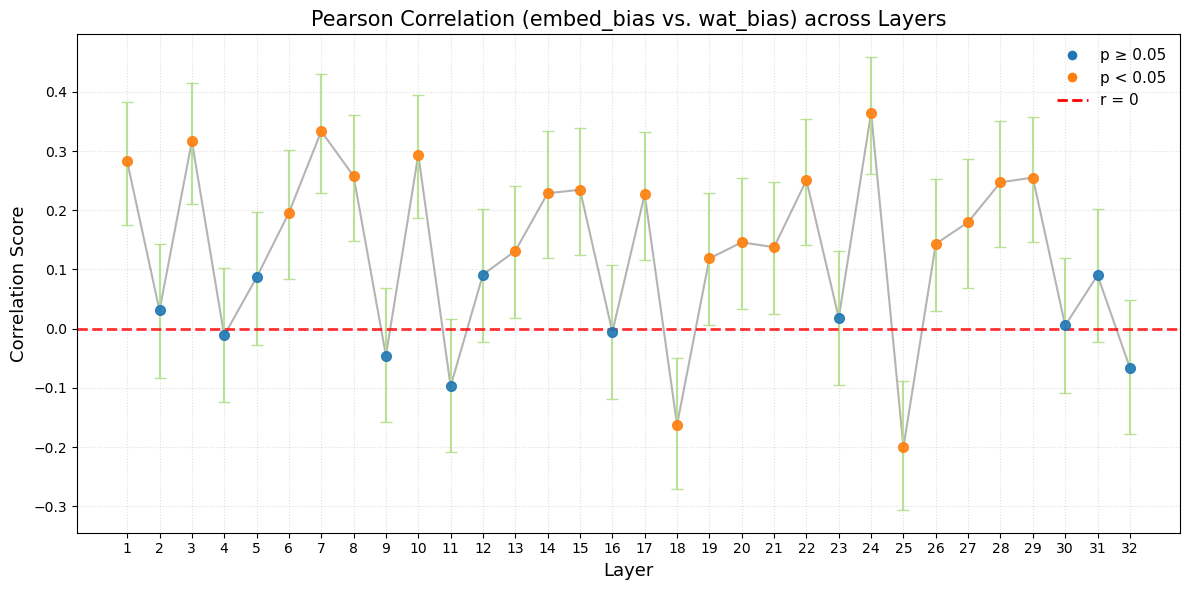

In [22]:
import pandas as pd
import numpy as np
import dask.bag as db
from scipy.stats import pearsonr, norm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --------- 1. 定义计算函数 ---------
def fisher_confidence_interval(r, n, alpha=0.05):
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    z_low = z - z_crit * se
    z_high = z + z_crit * se
    return np.tanh(z_low), np.tanh(z_high)

def compute_corr_ci(layer_df_pair):
    layer, df = layer_df_pair
    df = df[['test_stat', 'iat_bias']].dropna()
    n = len(df)
    if n < 4:
        return (layer, np.nan, np.nan, np.nan, np.nan)
    r, p = pearsonr(df['test_stat'], df['iat_bias'])
    ci_low, ci_high = fisher_confidence_interval(r, n)
    return (layer, r, p, ci_low, ci_high)

# --------- 2. 构造 Dask Bag 并并行计算 ---------
# 提取所有存在的层
layers_to_run = merged_df['layer'].dropna().unique().astype(int)
layer_dfs = [(layer, merged_df[merged_df['layer'] == layer]) for layer in layers_to_run]

# 转换为 Dask Bag 并并行运行
bag = db.from_sequence(layer_dfs, npartitions=8)
results = bag.map(compute_corr_ci).compute()

# 转为 DataFrame，按 layer 排序
corr_df = pd.DataFrame(results, columns=[
    'layer', 'correlation', 'p_value', 'ci_lower', 'ci_upper'
]).sort_values('layer')

# --------- 3. 绘图 ---------
layers = corr_df['layer'].values
corrs = corr_df['correlation'].values
pvals = corr_df['p_value'].values
ci_low = corr_df['ci_lower'].values
ci_high = corr_df['ci_upper'].values
errors = [corrs - ci_low, ci_high - corrs]

highlight_color = '#1f77b4'
sig_color = '#ff7f0e'
ci_color = '#b2df8a'
line_color = '#444444'

plt.figure(figsize=(12, 6))

# 连线图层之间
for i in range(len(layers) - 1):
    x_pair = [layers[i], layers[i + 1]]
    y_pair = [corrs[i], corrs[i + 1]]
    if not np.isnan(y_pair[0]) and not np.isnan(y_pair[1]):
        plt.plot(x_pair, y_pair, color=line_color, alpha=0.4, linewidth=1.5)

# 图例
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='p ≥ 0.05',
           markerfacecolor=highlight_color, markersize=8),
    Line2D([0], [0], marker='o', color='w', label='p < 0.05',
           markerfacecolor=sig_color, markersize=8),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='r = 0')
]

# 添加误差条
for i, (r, p, err_low, err_high) in enumerate(zip(corrs, pvals, errors[0], errors[1])):
    if np.isnan(r):
        continue
    color = sig_color if p < 0.05 else highlight_color
    plt.errorbar(layers[i], r,
                 yerr=[[err_low], [err_high]],
                 fmt='o', color=color, ecolor=ci_color,
                 capsize=4, markersize=7, alpha=0.9)

plt.axhline(0, color='red', linewidth=2, linestyle='--', alpha=0.8)
plt.legend(handles=legend_elements, loc='upper right', fontsize=11, frameon=False)
plt.xlabel('Layer', fontsize=13)
plt.ylabel('Correlation Score', fontsize=13)
plt.title('Pearson Correlation (embed_bias vs. wat_bias) across Layers', fontsize=15)
plt.xticks(layers)
plt.grid(True, linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()


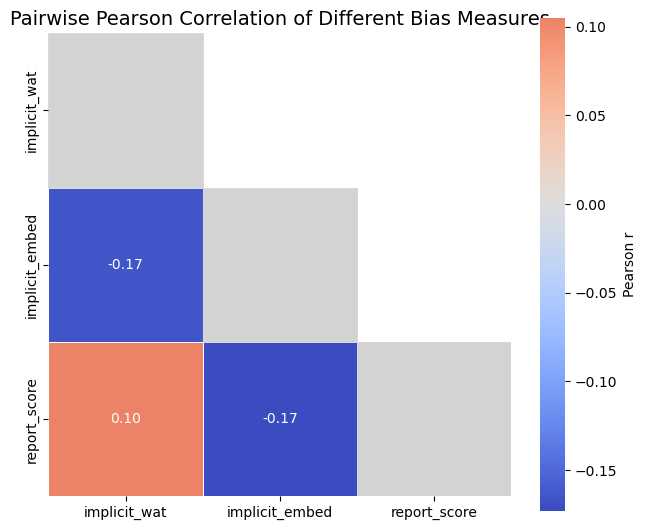

In [25]:
import dask.bag as db
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from dask import compute

# 1. Select and rename the relevant columns
df_corr = merged_df[['iat_bias', 'test_stat', 'report_score']].dropna().tail(100)
df_corr = df_corr.rename(columns={
    'iat_bias': 'implicit_wat',
    'test_stat': 'implicit_embed',
    'report_binary': 'explicit_report'
})

# 2. Create list of variables and all possible pairs (including symmetric)
variables = df_corr.columns.tolist()
var_pairs = [(v1, v2) for v1 in variables for v2 in variables]

# 3. Define correlation computation function
def compute_corr_p(pair):
    v1, v2 = pair
    r, p = pearsonr(df_corr[v1], df_corr[v2])
    return (v1, v2, r, p)

# 4. Use Dask Bag to parallelize across variable pairs
bag = db.from_sequence(var_pairs, npartitions=16)
results = bag.map(compute_corr_p).compute()

# 5. Build correlation and p-value matrices
corr_matrix = pd.DataFrame(index=variables, columns=variables, dtype=float)
pval_matrix = pd.DataFrame(index=variables, columns=variables, dtype=float)

for v1, v2, r, p in results:
    corr_matrix.loc[v1, v2] = r
    pval_matrix.loc[v1, v2] = p

# 6. Annotate significance stars
sig_annot = corr_matrix.copy()
for i in variables:
    for j in variables:
        r = corr_matrix.loc[i, j]
        p = pval_matrix.loc[i, j]
        star = ''
        if p < 0.001:
            star = '***'
        elif p < 0.01:
            star = '**'
        elif p < 0.05:
            star = '*'
        sig_annot.loc[i, j] = f"{r:.2f}{star}"

# 7. Optional: mask upper triangle for display
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

# Result: sig_annot holds annotated correlation values (with stars)

# Plot heatmap
plt.figure(figsize=(6.5, 5.5))
sns.heatmap(corr_matrix.astype(float),
            annot=sig_annot, fmt='',
            mask=mask,
            cmap="coolwarm", center=0,
            square=True, linewidths=0.5,
            cbar_kws={'label': 'Pearson r'})

# 灰色对角线
for i in range(len(variables)):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='lightgray', edgecolor='white', lw=0.5))

plt.title('Pairwise Pearson Correlation of Different Bias Measures', fontsize=14)
plt.tight_layout()
plt.show()


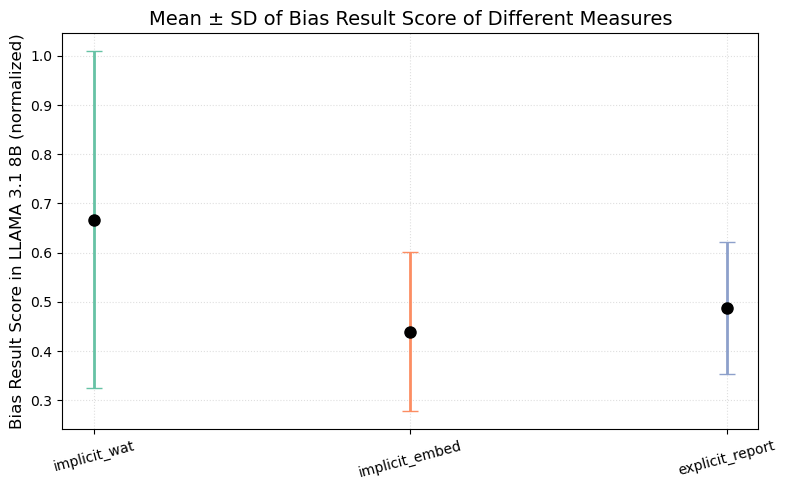

In [28]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Convert merged_df to Dask DataFrame
ddf = dd.from_pandas(merged_df, npartitions=4)

# 明确列结构（meta）：使用你实际列类型
meta = {
    'iat_bias': 'f8',
    'test_stat': 'f8',
    'label': 'i8',
    'report_score': 'f8'
}

# 安全 dropna（不加 meta）
ddf_corr = ddf[['iat_bias', 'test_stat','report_score']]

# 强制类型转换（可选，如果你担心类型不一致）
ddf_corr = ddf_corr.astype({
    'iat_bias': 'float64',
    'test_stat': 'float64',
    'report_score': 'float64'
})

# 转回 pandas 并取后 100 行
df_corr = ddf_corr.compute().tail(100)

# 4. Rename columns
df_corr = df_corr.rename(columns={
    'iat_bias': 'implicit_wat',
    'test_stat': 'implicit_embed',
    'report_score': 'explicit_report'
})

# 5. Normalize continuous columns
continuous_cols = ['implicit_wat', 'implicit_embed', 'explicit_report']
df_corr[continuous_cols] = (
    df_corr[continuous_cols] - df_corr[continuous_cols].min()
) / (
    df_corr[continuous_cols].max() - df_corr[continuous_cols].min()
)

# 6. Parallel mean/std via Dask (if data is still large)
# But here, data already small → use Pandas
means = df_corr.mean()
stds = df_corr.std()

# 7. Plotting (no need to parallelize — plotting is always sequential)
plt.figure(figsize=(8, 5))
x = np.arange(len(means))
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

for i in range(len(means)):
    plt.errorbar(x[i], means.values[i], yerr=stds.values[i],
                 fmt='o', color='black', ecolor=colors[i],
                 elinewidth=2, capsize=6, markersize=8)

plt.xticks(x, means.index, rotation=15)
plt.ylabel('Bias Result Score in LLAMA 3.1 8B (normalized)', fontsize=12)
plt.title('Mean ± SD of Bias Result Score of Different Measures', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# # Subset last 100 rows
# df_subset = merged_df.tail(100)

# # Predictors to model
# predictors = ['iat_bias', 'test_stat']

# # Wrap logistic regression in a delayed function
# @delayed
# def run_logit(predictor, df):
#     X = sm.add_constant(df[predictor])
#     y = df['label']
#     model = sm.Logit(y, X).fit(disp=0)

#     params = model.params
#     conf = model.conf_int()
#     conf.columns = ['CI_lower', 'CI_upper']

#     summary_df = pd.concat([params, conf], axis=1).reset_index()
#     summary_df.columns = ['Predictor', 'B', 'CI_lower', 'CI_upper']

#     summary_df['Coefficient (95% CI)'] = summary_df.apply(
#         lambda row: f"{row['B']:.3f} ({row['CI_lower']:.3f}, {row['CI_upper']:.3f})", axis=1
#     )

#     table = summary_df[['Predictor', 'Coefficient (95% CI)']]

#     stats_summary = {
#         "predictor": predictor,
#         "apa_table": table.to_html(index=False, border=0),
#         "aic": model.aic,
#         "bic": model.bic,
#         "pseudo_r2": model.prsquared
#     }
#     return stats_summary

# # Create and run tasks
# tasks = [run_logit(predictor, df_subset) for predictor in predictors]
# results = compute(*tasks)

# # Display results
# for result in results:
#     print(f"\n📌 Predictor: {result['predictor']}")
#     display(HTML(result['apa_table']))
#     print(f"AIC = {result['aic']:.3f}, BIC = {result['bic']:.3f}, Pseudo R² = {result['pseudo_r2']:.3f}")




📌 Predictor: iat_bias


Predictor,Coefficient (95% CI)
const,"1.576 (0.832, 2.319)"
iat_bias,"2.691 (1.333, 4.048)"


AIC = 52.260, BIC = 57.471, Pseudo R² = 0.304

📌 Predictor: test_stat


Predictor,Coefficient (95% CI)
const,"2.271 (1.394, 3.149)"
test_stat,"19.392 (-41.285, 80.069)"


AIC = 72.908, BIC = 78.118, Pseudo R² = 0.006


In [ ]:
# @delayed
# def run_logit_for_layer(layer, df):
#     layer_df = df[df['layer'] == layer].head(100)

#     if len(layer_df) < 10 or layer_df['label'].nunique() < 2:
#         return {
#             'layer': layer, 'coef': None, 'p_value': None,
#             'r2': None, 'ci_low': None, 'ci_high': None
#         }

#     try:
#         X = sm.add_constant(layer_df['test_stat'])
#         y = layer_df['label']
#         model = sm.Logit(y, X).fit(disp=0)

#         coef = model.params['test_stat']
#         p_value = model.pvalues['test_stat']
#         pseudo_r2 = model.prsquared
#         se = model.bse['test_stat']

#         ci_low = coef - 1.96 * se
#         ci_high = coef + 1.96 * se

#         return {
#             'layer': layer,
#             'coef': coef,
#             'p_value': p_value,
#             'r2': pseudo_r2,
#             'ci_low': ci_low,
#             'ci_high': ci_high
#         }

#     except Exception as e:
#         print(f"Layer {layer} failed: {e}")
#         return {
#             'layer': layer, 'coef': None, 'p_value': None,
#             'r2': None, 'ci_low': None, 'ci_high': None
#         }

# # Create parallel tasks for each layer
# tasks = [run_logit_for_layer(layer, merged_df) for layer in range(1, 33)]

# # Trigger parallel execution
# results = compute(*tasks)

# # Convert to DataFrame
# logit_results_df = pd.DataFrame(results)


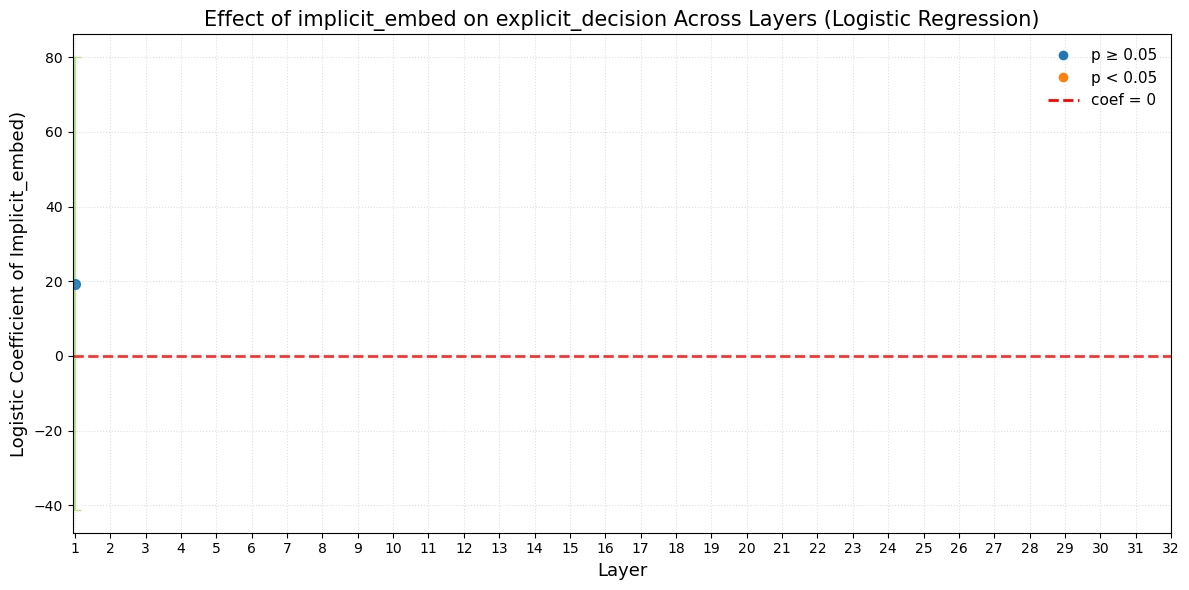

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.lines import Line2D

# layers = logit_results_df['layer'].values
# coefs = logit_results_df['coef'].values
# pvals = logit_results_df['p_value'].values
# ci_low = logit_results_df['ci_low'].values
# ci_high = logit_results_df['ci_high'].values

# errors = [coefs - ci_low, ci_high - coefs]

# highlight_color = '#1f77b4'  # 非显著 蓝
# sig_color = '#ff7f0e'        # 显著 橙
# ci_color = '#b2df8a'         # 置信区间 浅绿
# line_color = '#444444'       # 连线 灰

# plt.figure(figsize=(12, 6))

# # 相邻点连线
# for i in range(len(layers) - 1):
#     if np.isnan(coefs[i]) or np.isnan(coefs[i + 1]):
#         continue
#     plt.plot([layers[i], layers[i + 1]], [coefs[i], coefs[i + 1]],
#              color=line_color, alpha=0.4, linewidth=1.5)

# # 图例说明
# legend_elements = [
#     Line2D([0], [0], marker='o', color='w', label='p ≥ 0.05',
#            markerfacecolor=highlight_color, markersize=8),
#     Line2D([0], [0], marker='o', color='w', label='p < 0.05',
#            markerfacecolor=sig_color, markersize=8),
#     Line2D([0], [0], color='red', lw=2, linestyle='--', label='coef = 0')
# ]

# # 每个点 + 误差条
# for i, (coef, p, err_low, err_high) in enumerate(zip(coefs, pvals, errors[0], errors[1])):
#     if np.isnan(coef):
#         continue
#     color = sig_color if p < 0.05 else highlight_color
#     plt.errorbar(layers[i], coef,
#                  yerr=[[err_low], [err_high]],
#                  fmt='o', color=color, ecolor=ci_color,
#                  capsize=4, markersize=7, alpha=0.9)

# # 添加参考线 y=0
# plt.axhline(0, color='red', linewidth=2, linestyle='--', alpha=0.8)

# # 图例与标签
# plt.legend(handles=legend_elements, loc='upper right', fontsize=11, frameon=False)
# plt.xlabel('Layer', fontsize=13)
# plt.ylabel('Logistic Coefficient of Implicit_embed)', fontsize=13)
# plt.title('Effect of implicit_embed on explicit_decision Across Layers (Logistic Regression)', fontsize=15)
# plt.xticks(np.arange(1, 33))
# plt.grid(True, linestyle=':', alpha=0.4)
# plt.tight_layout()
# plt.show()


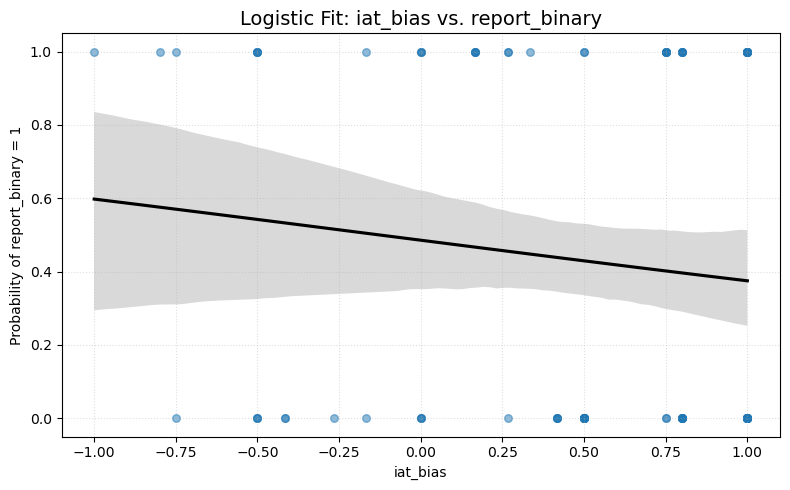

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 5))
# sns.regplot(x='iat_bias', y='report_binary', data=df_subset, logistic=True,
#             ci=95, scatter_kws={'s': 30, 'alpha': 0.5}, line_kws={'color': 'black'})

# plt.title('Logistic Fit: iat_bias vs. report_binary', fontsize=14)
# plt.xlabel('iat_bias')
# plt.ylabel('Probability of report_binary = 1')
# plt.grid(True, linestyle=':', alpha=0.4)
# plt.tight_layout()
# plt.show()


In [45]:
client.shutdown()
cluster.close()